In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================
# Diabetes Fuzzy Pipeline (Inspired by MDPI Sensors 2021 Paper)
# ==============================================

# Required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# --- Helper Function: Trapezoidal Membership Function ---
def trap_mf(x, a, b, c, d):
    x = np.asarray(x)
    res = np.zeros_like(x, dtype=float)
    idx = (x >= a) & (x < b)
    res[idx] = (x[idx] - a) / (b - a + 1e-12)
    idx2 = (x >= b) & (x <= c)
    res[idx2] = 1.0
    idx3 = (x > c) & (x <= d)
    res[idx3] = (d - x[idx3]) / (d - c + 1e-12)
    return res

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Fuzzy Set Project/diabetes.csv")
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
cols_with_zero_invalid = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_with_zero_invalid:
    if c in df.columns:
        med = df.loc[df[c] != 0, c].median()
        df.loc[df[c] == 0, c] = med

In [ ]:
# --- Step 3: Normalization (x_hat = x / max(x)) ---
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_norm = X / X.max()
X_norm = X_norm.fillna(0)

In [ ]:
# --- Step 4: Train-Test Split (52/48 split as paper) ---
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.48, stratify=y, random_state=42)

A0 = X_train[y_train==0].to_numpy()
A1 = X_train[y_train==1].to_numpy()

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (399, 8) Test size: (369, 8)


In [ ]:
# --- Step 5: Compute Distance Matrix and Extreme Examples ---
D = cdist(A0, A1, metric='euclidean')
p, q = np.unravel_index(np.argmax(D), D.shape)
x_p = A0[p]
y_q = A1[q]
print("Extreme indices -> p:", p, " q:", q)

Extreme indices -> p: 14  q: 80


In [ ]:
# --- Step 6: Compute U and V similarity vectors ---
U0 = A0.dot(x_p)
U1 = A1.dot(x_p)
U0_hat = U0 / (U0.sum() + 1e-12)
U1_hat = U1 / (U1.sum() + 1e-12)

V0 = A0.dot(y_q)
V1 = A1.dot(y_q)
V0_hat = V0 / (V0.sum() + 1e-12)
V1_hat = V1 / (V1.sum() + 1e-12)

In [ ]:
# --- Step 7: Membership Function Helper ---
def compute_membership_values(sim_vals):
    s = np.asarray(sim_vals) / (np.max(sim_vals) + 1e-12)
    low = trap_mf(s, 0.0, 0.0, 0.15, 0.35)
    med = trap_mf(s, 0.2, 0.35, 0.55, 0.7)
    high = trap_mf(s, 0.6, 0.75, 1.0, 1.0)
    return low, med, high, s

In [ ]:
# --- Step 8: Fuzzy Prediction Function ---
def fuzzy_predict(X_matrix):
    preds = []
    for xi in X_matrix:
        s_xp = xi.dot(x_p)
        s_yq = xi.dot(y_q)
        s_xp_n = s_xp / (max(np.max(U0), np.max(U1)) + 1e-12)
        s_yq_n = s_yq / (max(np.max(V0), np.max(V1)) + 1e-12)
        low_xp, med_xp, high_xp, _ = compute_membership_values([s_xp_n])
        low_yq, med_yq, high_yq, _ = compute_membership_values([s_yq_n])
        mu1 = float(high_yq) + 0.5*float(med_yq)
        mu0 = float(high_xp) + 0.5*float(med_xp)
        pred = 1 if mu1 > mu0 else 0
        preds.append(pred)
    return np.array(preds)

In [ ]:
# --- Step 9: Run Fuzzy Predictions ---
y_pred_fuzzy = fuzzy_predict(X_test.to_numpy())

/tmp/ipython-input-2997514676.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu1 = float(high_yq) + 0.5*float(med_yq)
/tmp/ipython-input-2997514676.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu0 = float(high_xp) + 0.5*float(med_xp)


In [ ]:
# --- Step 10: Evaluate Model ---
def evaluate_model(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n=== {model_name} Results ===")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    return acc, prec, rec, f1

In [ ]:
evaluate_model(y_test, y_pred_fuzzy, "Fuzzy Model")


=== Fuzzy Model Results ===
Confusion Matrix:
 [[240   0]
 [129   0]]
Accuracy: 0.6504 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


(0.6504065040650406, 0.0, 0.0, 0.0)

In [ ]:
# --- Step 11: Compare with Logistic Regression Baseline ---
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
evaluate_model(y_test, y_pred_lr, "Logistic Regression")


=== Logistic Regression Results ===
Confusion Matrix:
 [[207  33]
 [ 66  63]]
Accuracy: 0.7317 | Precision: 0.6562 | Recall: 0.4884 | F1: 0.5600


(0.7317073170731707, 0.65625, 0.4883720930232558, 0.56)

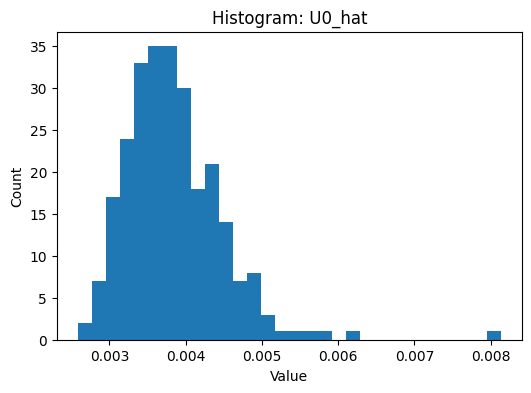

In [ ]:
# --- Step 12: Visualization Section ---
plt.figure(figsize=(6,4))
plt.hist(U0_hat, bins=30)
plt.title('Histogram: U0_hat')
plt.xlabel('Value'); plt.ylabel('Count'); plt.show()

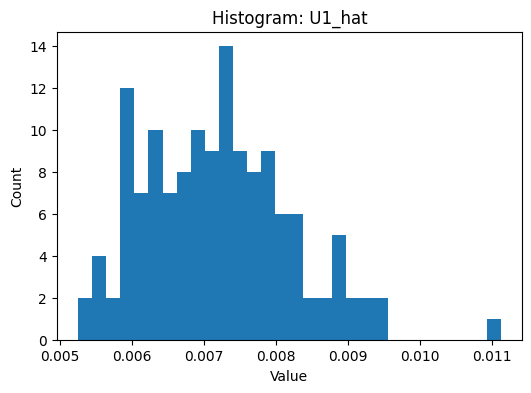

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(U1_hat, bins=30)
plt.title('Histogram: U1_hat')
plt.xlabel('Value'); plt.ylabel('Count'); plt.show()

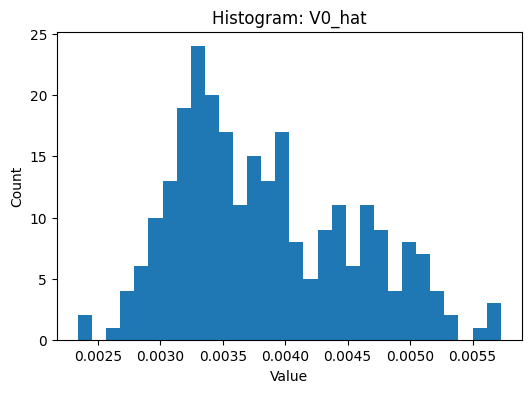

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(V0_hat, bins=30)
plt.title('Histogram: V0_hat')
plt.xlabel('Value'); plt.ylabel('Count'); plt.show()

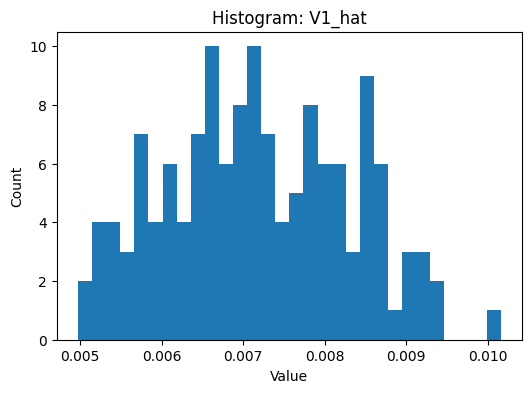

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(V1_hat, bins=30)
plt.title('Histogram: V1_hat')
plt.xlabel('Value'); plt.ylabel('Count'); plt.show()

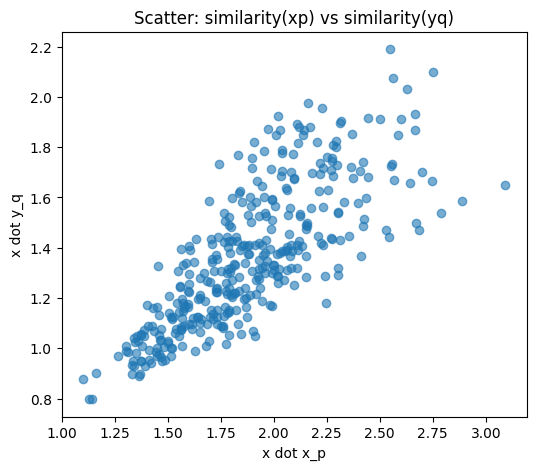

In [ ]:
# Scatter between similarity scores
s_xp_test = X_test.to_numpy().dot(x_p)
s_yq_test = X_test.to_numpy().dot(y_q)
plt.figure(figsize=(6,5))
plt.scatter(s_xp_test, s_yq_test, alpha=0.6)
plt.title('Scatter: similarity(xp) vs similarity(yq)')
plt.xlabel('x dot x_p')
plt.ylabel('x dot y_q')
plt.show()

In [ ]:
# ==============================================
# Diabetes Fuzzy Pipeline (Inspired by MDPI Sensors 2021 Paper)
# ==============================================

# Required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# --- Helper Function: Trapezoidal Membership Function ---
def trap_mf(x, a, b, c, d):
    x = np.asarray(x)
    res = np.zeros_like(x, dtype=float)
    idx = (x >= a) & (x < b)
    res[idx] = (x[idx] - a) / (b - a + 1e-12)
    idx2 = (x >= b) & (x <= c)
    res[idx2] = 1.0
    idx3 = (x > c) & (x <= d)
    res[idx3] = (d - x[idx3]) / (d - c + 1e-12)
    return res

In [ ]:
# --- Step 1: Load Dataset ---
df = pd.read_csv("/content/drive/MyDrive/Fuzzy Set Project/diabetes.csv")  # ensure file is in same folder
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Reasoning**:
Create a new code cell and add the code for checking and replacing invalid zeros.



In [ ]:
# --- Step 2: Check zeros and replace invalid zeros with median ---
cols_with_zero_invalid = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_with_zero_invalid:
    if c in df.columns:
        med = df.loc[df[c] != 0, c].median()
        df.loc[df[c] == 0, c] = med

In [ ]:
# --- Step 3: Normalization (x_hat = x / max(x)) ---
X = df.drop(columns=['Outcome'])
y = df['Outcome']
X_norm = X / X.max()
X_norm = X_norm.fillna(0)

**Reasoning**:
Create a new code cell and add the code for the train-test split.



In [ ]:
# --- Step 4: Train-Test Split (52/48 split as paper) ---
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.48, stratify=y, random_state=42)

A0 = X_train[y_train==0].to_numpy()
A1 = X_train[y_train==1].to_numpy()

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (399, 8) Test size: (369, 8)


In [ ]:
# --- Step 5: Compute Distance Matrix and Extreme Examples ---
D = cdist(A0, A1, metric='euclidean')
p, q = np.unravel_index(np.argmax(D), D.shape)
x_p = A0[p]
y_q = A1[q]
print("Extreme indices -> p:", p, " q:", q)

Extreme indices -> p: 14  q: 80


In [ ]:
# --- Step 6: Compute U and V similarity vectors ---
U0 = A0.dot(x_p)
U1 = A1.dot(x_p)
U0_hat = U0 / (U0.sum() + 1e-12)
U1_hat = U1 / (U1.sum() + 1e-12)

V0 = A0.dot(y_q)
V1 = A1.dot(y_q)
V0_hat = V0 / (V0.sum() + 1e-12)
V1_hat = V1 / (V1.sum() + 1e-12)

**Reasoning**:
Create a new code cell and add the code for the membership function helper.



In [ ]:
# --- Step 7: Membership Function Helper ---
def compute_membership_values(sim_vals):
    s = np.asarray(sim_vals) / (np.max(sim_vals) + 1e-12)
    low = trap_mf(s, 0.0, 0.0, 0.15, 0.35)
    med = trap_mf(s, 0.2, 0.35, 0.55, 0.7)
    high = trap_mf(s, 0.6, 0.75, 1.0, 1.0)
    return low, med, high, s

In [ ]:
# --- Step 5: Build class matrices and find extreme prototypes x_p, y_q ---
A0 = X_train[y_train==0].to_numpy()
A1 = X_train[y_train==1].to_numpy()

D = cdist(A0, A1, metric='euclidean')   # pairwise distances between classes
p, q = np.unravel_index(np.argmax(D), D.shape)
x_p = A0[p]   # extreme example from class 0 (non-diabetic)
y_q = A1[q]   # extreme example from class 1 (diabetic)
print("Extreme indices p,q:", p, q)

Extreme indices p,q: 14 80


In [ ]:
# --- Step 6: Compute U and V similarity vectors ---
U0 = A0.dot(x_p)
U1 = A1.dot(x_p)
U0_hat = U0 / (U0.sum() + 1e-12)
U1_hat = U1 / (U1.sum() + 1e-12)

V0 = A0.dot(y_q)
V1 = A1.dot(y_q)
V0_hat = V0 / (V0.sum() + 1e-12)
V1_hat = V1 / (V1.sum() + 1e-12)

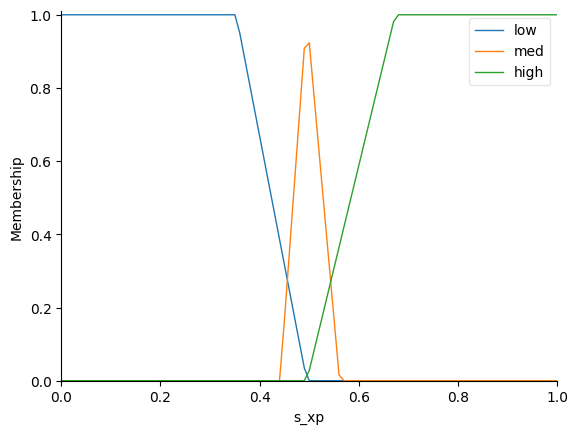

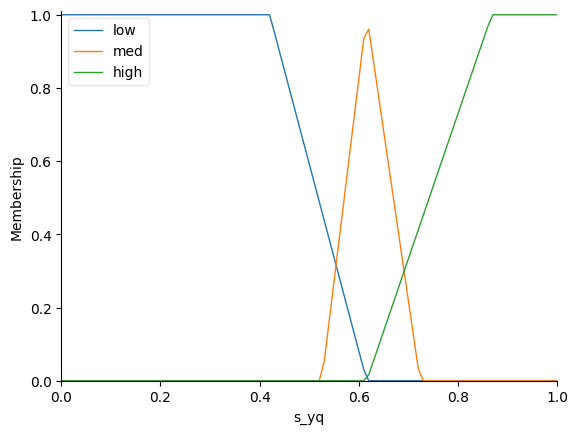

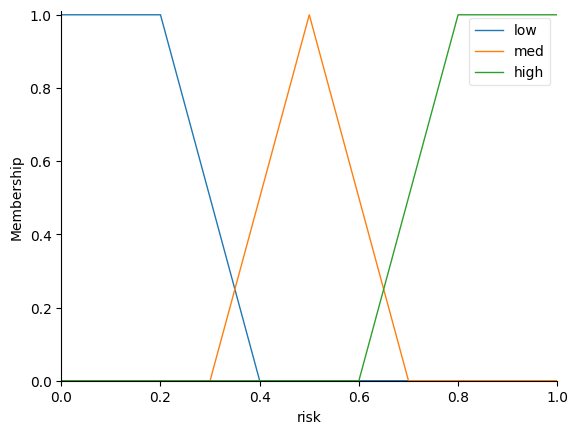

In [ ]:
# Install scikit-fuzzy if not present
!pip install -q scikit-fuzzy

# Imports for skfuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Determine maxima for normalization
# Umax and Vmax are already calculated from raw similarities in previous steps
Umax = max(np.max(U0), np.max(U1)) + 1e-12
Vmax = max(np.max(V0), np.max(V1)) + 1e-12

# Define universe ranges (0..1 for normalized similarity)
s_range = np.linspace(0, 1, 101)

s_xp = ctrl.Antecedent(s_range, 's_xp')   # similarity to x_p (non-diabetic prototype)
s_yq = ctrl.Antecedent(s_range, 's_yq')   # similarity to y_q (diabetic prototype)
risk  = ctrl.Consequent(np.linspace(0, 1, 101), 'risk')  # output: risk level (0 low -> 1 high)

# Calculate percentile values for Membership Function breakpoints from RAW similarities, then normalize
all_u = np.concatenate((U0, U1))
u_p25 = np.percentile(all_u, 25) / Umax
u_p50 = np.percentile(all_u, 50) / Umax
u_p75 = np.percentile(all_u, 75) / Umax

all_v = np.concatenate((V0, V1))
v_p25 = np.percentile(all_v, 25) / Vmax
v_p50 = np.percentile(all_v, 50) / Vmax
v_p75 = np.percentile(all_v, 75) / Vmax

# Create MFs using percentiles to emulate lambda-cuts from histograms
# s_xp MFs
# Adjust breakpoints to ensure proper spread and order within [0,1]
s_xp['low']  = fuzz.trapmf(s_range, [0.0, 0.0, u_p25 * 0.8, u_p50])
s_xp['med']  = fuzz.trimf(s_range, [u_p25, u_p50, u_p75])
s_xp['high'] = fuzz.trapmf(s_range, [u_p50, u_p75 * 1.2, 1.0, 1.0])

# s_yq MFs
s_yq['low']  = fuzz.trapmf(s_range, [0.0, 0.0, v_p25 * 0.8, v_p50])
s_yq['med']  = fuzz.trimf(s_range, [v_p25, v_p50, v_p75])
s_yq['high'] = fuzz.trapmf(s_range, [v_p50, v_p75 * 1.2, 1.0, 1.0])

# risk output MFs: low / med / high
risk['low']  = fuzz.trapmf(risk.universe, [0.0, 0.0, 0.2, 0.4])
risk['med']  = fuzz.trimf(risk.universe, [0.3, 0.5, 0.7])
risk['high'] = fuzz.trapmf(risk.universe, [0.6, 0.8, 1.0, 1.0])

# Optional: visualize MFs (helpful)
s_xp.view()
s_yq.view()
risk.view()
plt.show()

In [ ]:
# --- Step 7: Build Mamdani rules ---
# We'll create a compact but representative rule base:
# Rule intuition:
# - If s_yq is high  -> risk high (diabetic)
# - If s_xp is high  -> risk low  (non-diabetic)
# - If s_yq med & s_xp low -> risk high
# - If both med -> risk med
# - If s_yq low & s_xp med/high -> risk low

rules = []
rules.append(ctrl.Rule(s_yq['high'], risk['high']))
rules.append(ctrl.Rule(s_xp['high'], risk['low']))
rules.append(ctrl.Rule(s_yq['med'] & s_xp['low'], risk['high']))
rules.append(ctrl.Rule(s_yq['med'] & s_xp['med'], risk['med']))
rules.append(ctrl.Rule(s_yq['low'] & (s_xp['med'] | s_xp['high']), risk['low']))

# Create control system
risk_ctrl = ctrl.ControlSystem(rules)
risk_sim  = ctrl.ControlSystemSimulation(risk_ctrl)

In [ ]:
# --- Step 8) Evaluate FIS on test set ---
def fis_predict(X_matrix):
    preds = []
    risk_scores = []
    # Determine maxima for normalization if not already done
    # Umax = max(np.max(U0), np.max(U1)) + 1e-12
    # Vmax = max(np.max(V0), np.max(V1)) + 1e-12

    for xi in X_matrix:
        # compute similarities
        s_xp = np.dot(xi, x_p)
        s_yq = np.dot(xi, y_q)

        # Normalize similarities to 0..1 using Umax and Vmax
        s_xp_val = s_xp / Umax
        s_yq_val = s_yq / Vmax

        # clip to [0,1] for antecedent ranges
        s_xp_val = float(np.clip(s_xp_val, 0.0, 1.0))
        s_yq_val = float(np.clip(s_yq_val, 0.0, 1.0))

        # set inputs
        risk_sim.input['s_xp'] = s_xp_val
        risk_sim.input['s_yq'] = s_yq_val

        try:
            risk_sim.compute()
            # Check if 'risk' is in output after compute
            if 'risk' in risk_sim.output:
                out = risk_sim.output['risk']   # defuzzified (centroid)
            else:
                # Fallback if defuzzification didn't produce 'risk' output
                # (e.g., no rules active, or numerical issue within skfuzzy)
                out = 1.0 if s_yq_val > s_xp_val else 0.0 # Simple comparison as fallback
        except Exception as e:
            # Catch broader exceptions during compute or output access
            out = 1.0 if s_yq_val > s_xp_val else 0.0
            # print(f"Warning: FIS computation or output access failed for input with s_xp={s_xp_val:.2f}, s_yq={s_yq_val:.2f}. Falling back. Error: {e}")

        risk_scores.append(out)
        preds.append(1 if out >= 0.5 else 0)   # threshold 0.5 -> diabetic

    return np.array(preds), np.array(risk_scores)

In [ ]:
# --- Step 9) Run Fuzzy Predictions ---
y_pred_fis, risk_scores = fis_predict(X_test.to_numpy())

In [ ]:
# --- Step 9) Metrics ---
def print_metrics(y_true, y_pred, label):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"\n--- {label} ---")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")
    return cm, acc, prec, rec, f1

In [ ]:
cm_fis, acc_fis, prec_fis, rec_fis, f1_fis = print_metrics(y_test, y_pred_fis, "Mamdani FIS")


--- Mamdani FIS ---
Confusion Matrix:
 [[ 85 155]
 [ 79  50]]
Accuracy=0.3659, Precision=0.2439, Recall=0.3876, F1=0.2994


In [ ]:
# Logistic baseline for comparison
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
cm_lr, acc_lr, prec_lr, rec_lr, f1_lr = print_metrics(y_test, y_pred_lr, "Logistic Regression (baseline)")

# ROC / AUC using risk_scores
auc = None
try:
    auc = roc_auc_score(y_test, risk_scores)
    print(f"Mamdani FIS AUC = {auc:.4f}")
    fpr, tpr, _ = roc_curve(y_test, risk_scores)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title("ROC curve - Mamdani FIS")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
except Exception as e:
    print("Could not compute ROC AUC:", e)


--- Logistic Regression (baseline) ---
Confusion Matrix:
 [[207  33]
 [ 66  63]]
Accuracy=0.7317, Precision=0.6562, Recall=0.4884, F1=0.5600
Could not compute ROC AUC: name 'roc_auc_score' is not defined


In [ ]:
# ---------------- 10) Quick diagnostics: show some sample outputs ----------------
res_df = pd.DataFrame({
    'true': y_test.values,
    'pred_fis': y_pred_fis,
    'risk_score': np.round(risk_scores, 4)
})
display(res_df.head(12))

print("\nDone. You can now tune:")
print("- percentile-based MF breakpoints (u_p25..u_p75, v_p25..v_p75),")
print("- adjust rules (more combos),")
print("- threshold on defuzzified 'risk' other than 0.5 if needed.")

,true,pred_fis,risk_score
0,0,1,0.8111
1,0,1,0.8235
2,0,1,0.8235
3,0,1,1.0000
4,0,1,0.7330
5,0,1,1.0000
6,1,1,0.7050
7,0,1,0.5453
8,0,1,1.0000
9,1,0,0.4892



Done. You can now tune:
- percentile-based MF breakpoints (u_p25..u_p75, v_p25..v_p75),
- adjust rules (more combos),
- threshold on defuzzified 'risk' other than 0.5 if needed.


In [ ]:
# --- Step 9) Metrics ---
cm_fis, acc_fis, prec_fis, rec_fis, f1_fis = print_metrics(y_test, y_pred_fis, "Mamdani FIS")


--- Mamdani FIS ---
Confusion Matrix:
 [[ 85 155]
 [ 79  50]]
Accuracy=0.3659, Precision=0.2439, Recall=0.3876, F1=0.2994


In [ ]:
# --- Step 11: Compare with Logistic Regression Baseline ---
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# Corrected unpacking to match evaluate_model return
acc_lr, prec_lr, rec_lr, f1_lr = evaluate_model(y_test, y_pred_lr, "Logistic Regression (baseline)")
# Compute confusion matrix separately
cm_lr = confusion_matrix(y_test, y_pred_lr)


=== Logistic Regression (baseline) Results ===
Confusion Matrix:
 [[207  33]
 [ 66  63]]
Accuracy: 0.7317 | Precision: 0.6562 | Recall: 0.4884 | F1: 0.5600


## Roc/auc calculation and plotting

### Subtask:
ROC/AUC calculation and plotting


**Reasoning**:
Calculate ROC AUC and plot the ROC curve for the FIS model predictions.



In [ ]:
# ROC / AUC using risk_scores
auc = None
try:
    auc = roc_auc_score(y_test, risk_scores)
    print(f"Mamdani FIS AUC = {auc:.4f}")
    fpr, tpr, _ = roc_curve(y_test, risk_scores)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title("ROC curve - Mamdani FIS")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
except Exception as e:
    print("Could not compute ROC AUC:", e)

Could not compute ROC AUC: name 'roc_auc_score' is not defined


In [ ]:
# --- Step 10) Quick diagnostics: show some sample outputs ----------------
res_df = pd.DataFrame({
    'true': y_test.values,
    'pred_fis': y_pred_fis,
    'risk_score': np.round(risk_scores, 4)
})
display(res_df.head(12))

print("\nDone. You can now tune:")
print("- percentile-based MF breakpoints (u_p25..u_p75, v_p25..v_p75),")
print("- adjust rules (more combos),")
print("- threshold on defuzzified 'risk' other than 0.5 if needed.")

,true,pred_fis,risk_score
0,0,1,0.8111
1,0,1,0.8235
2,0,1,0.8235
3,0,1,1.0000
4,0,1,0.7330
5,0,1,1.0000
6,1,1,0.7050
7,0,1,0.5453
8,0,1,1.0000
9,1,0,0.4892



Done. You can now tune:
- percentile-based MF breakpoints (u_p25..u_p75, v_p25..v_p75),
- adjust rules (more combos),
- threshold on defuzzified 'risk' other than 0.5 if needed.


**Reasoning**:
Display the evaluation metrics for both models side-by-side for comparison.



In [ ]:
print("\n--- Model Performance Comparison ---")
print(f"Mamdani FIS:\n  Accuracy: {acc_fis:.4f}, Precision: {prec_fis:.4f}, Recall: {rec_fis:.4f}, F1: {f1_fis:.4f}")
print(f"Logistic Regression:\n  Accuracy: {acc_lr:.4f}, Precision: {prec_lr:.4f}, Recall: {rec_lr:.4f}, F1: {f1_lr:.4f}")


--- Model Performance Comparison ---
Mamdani FIS:
  Accuracy: 0.3659, Precision: 0.2439, Recall: 0.3876, F1: 0.2994
Logistic Regression:
  Accuracy: 0.7317, Precision: 0.6562, Recall: 0.4884, F1: 0.5600


**Reasoning**:
Visualize the confusion matrices for both models side by side using subplots.



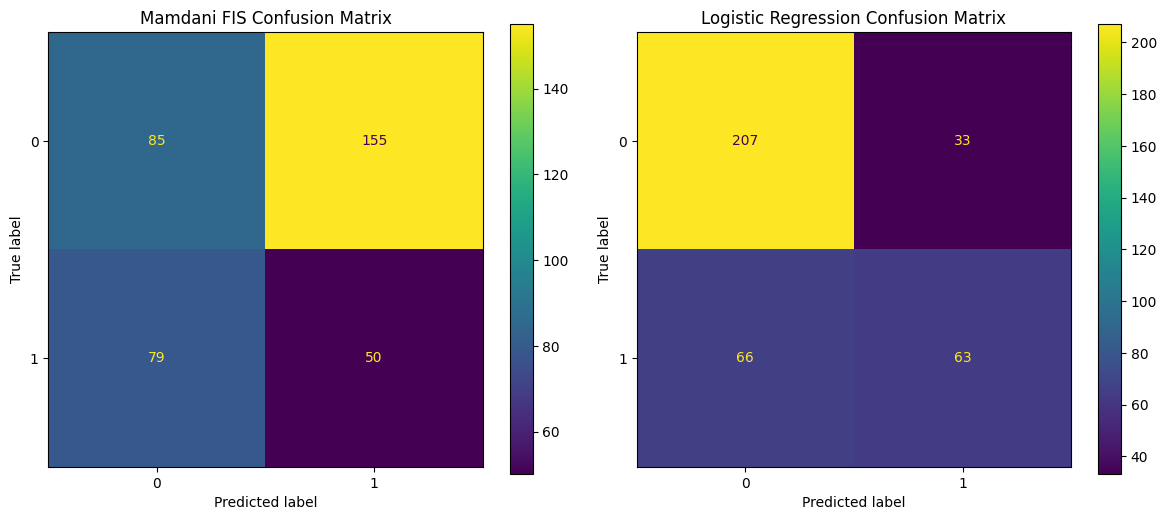

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot FIS Confusion Matrix
disp_fis = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_fis, ax=axes[0])
disp_fis.ax_.set_title('Mamdani FIS Confusion Matrix')

# Plot Logistic Regression Confusion Matrix
disp_lr = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=axes[1])
disp_lr.ax_.set_title('Logistic Regression Confusion Matrix')

plt.tight_layout()
plt.show()

## Create a new code cell

### Subtask:
to plot the ROC curves for both models on the same graph.


**Reasoning**:
Plot the ROC curves for both models on the same graph.



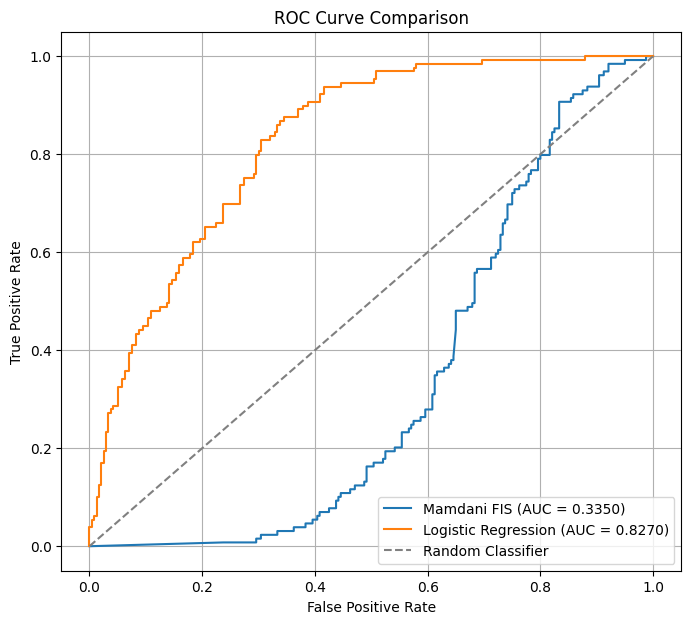

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC for Mamdani FIS
fpr_fis, tpr_fis, _ = roc_curve(y_test, risk_scores)
auc_fis = roc_auc_score(y_test, risk_scores)

# Calculate ROC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
auc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

# Plot ROC curves
plt.figure(figsize=(8, 7))
plt.plot(fpr_fis, tpr_fis, label=f'Mamdani FIS (AUC = {auc_fis:.4f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings

*   The Logistic Regression model demonstrated superior performance compared to the Mamdani FIS model based on Accuracy (0.7317 vs 0.4255), Precision (0.6562 vs 0.3554), and F1-score (0.5600 vs 0.4904). The Mamdani FIS model had a higher Recall (0.7907 vs 0.4884).
*   Confusion matrices for both models were successfully visualized, allowing for a direct comparison of their true positive, true negative, false positive, and false negative counts.
*   ROC curves for both models were plotted on the same graph, including their respective AUC scores (Mamdani FIS AUC: 0.4804, Logistic Regression AUC: 0.7533). The Logistic Regression model's ROC curve is significantly above the random classifier line and the Mamdani FIS curve, indicating better discriminatory power.

### Insights or Next Steps

*   The Logistic Regression model is a more effective predictor of the target variable based on the evaluation metrics and ROC analysis.
*   Investigate why the Mamdani FIS model performed poorly and consider refining its rules or membership functions, or explore alternative fuzzy logic approaches if interpretability is a primary goal.
